In [1]:
from noble_model_add_vgcc2 import ModifiedNobleModelCaL2
from fluorescence_encoder import FluorescenceEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from force_encoder.kato_force_encoder import KatoForceEncoder

In [2]:
T = 10
dt = 0.001

In [59]:
class SingleCellCalciumModelRyR(ModifiedNobleModelCaL2):
    def __init__(self):
        super().__init__()
        self.ct0 = 35
        self.gamma = 5.4054
        self.delta = 0.2
        self.v_r = 0.1
        self.K = 0.1
        self.time = np.linspace(0, T, int(T/dt))
    
    def i_ryr(self, c, c_t):
        return self.v_r * c**3 / (self.K**3 + c**3) * ((c_t-c)*self.gamma - c)
    
    def i_serca(self, c):
        v_serca = 12 # 14.5
        k_serca = 0.1
        return v_serca * c / (c + k_serca)
    
    def i_leak(self, c, c_t):
        v_leak = (- self.i_ryr(self.c0, self.ct0) \
                  + self.i_serca(self.c0)) \
                  / ((self.ct0-self.c0)*self.gamma - self.c0)
        
        return v_leak * ((c_t-c)*self.gamma - c)
    
    def i_pmca(self, c):
        k_pmca =  1.5 
        v_pmca = 11 # 12
        
        return v_pmca * c**2 / (k_pmca**2 + c**2)
    
    def i_soc(self, c, c_t):
        
        v_soc = 0
        k_soc = 0
        
        return v_soc * k_soc**4 / (k_soc**4 + ((c_t-c)*self.gamma)**4)
    
    def i_out(self, c):
        k_out = (- self.i_cal(self.v0, self.m_cal0, self.h_cal0) - self.i_pmca(self.c0) + self.i_soc(self.c0, self.ct0)) \
        / self.c0
        return k_out*c
    
    # Override
    def stim(self, t):
#         if t >= 10 and t < 10.1 or t >= 12 and t < 12.1 or t >= 14 and t < 14.1:
#             return 0.5
#         else:
#             return 0

        if t >= 1 and t < 1.1:
            return 0.5
        else:
            return 0
    
    def rhs(self, y, t):
        c, c_t, v, m, h, n, m_cal, h_cal = y
        
        dcdt = (self.i_ryr(c, c_t) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v, m_cal, h_cal) \
                + self.i_soc(c, c_t) \
                - self.i_out(c)) * self.delta
        
        dctdt = (- self.i_pmca(c) \
                       - self.i_cal(v, m_cal, h_cal) \
                       + self.i_soc(c, c_t) \
                       - self.i_out(c))\
                 * self.delta

        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
                  + 2*self.i_cal(v, m_cal, h_cal)\
                  - self.stim(t))/self.c_m
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        dmcaldt = (self.m_cal_inf(v) - m_cal) / self.tau_cal_m(v)
        dhcaldt = (self.h_cal_inf(v) - h_cal) / self.tau_cal_h(v)
        
        return [dcdt, dctdt, dvdt, dmdt, dhdt, dndt, dmcaldt, dhcaldt]
    
    # Override
    def step(self):
        y0 = [self.c0, self.ct0,
              self.v0, self.m0, self.h0, self.n0, self.m_cal0, self.h_cal0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol
    
    
    # Plot
    def plot(self, a, tmin=0, tmax=-1):
        
        plt.figure(figsize=(7,4))
        plt.plot(self.time[int(tmin/dt):int(tmax/dt)], a[int(tmin/dt):int(tmax/dt)])
        plt.show()

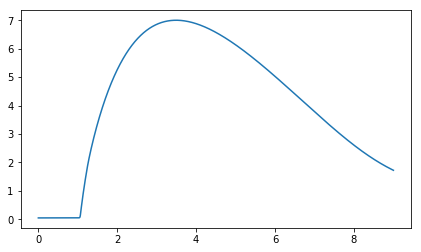

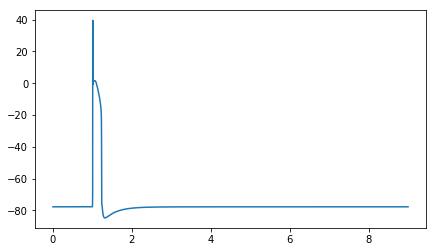

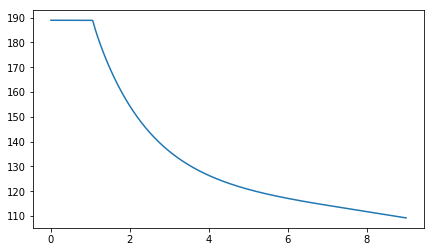

In [60]:
if __name__ == '__main__':
    aa = SingleCellCalciumModelRyR()
    sol = aa.step()
    c = sol[:,0]
    c_t = sol[:,1]
    v = sol[:,2]
    m = sol[:,3]
    h = sol[:,4]
    n = sol[:,5]
    m_cal = sol[:,6]
    h_cal = sol[:,7]
    aa.plot(c)
    aa.plot(v)
    aa.plot((c_t - c)*aa.gamma)

In [31]:
aa.step()

array([[ 5.00000000e-02,  3.50000000e+01, -7.77484558e+01, ...,
         9.71004663e-02,  5.09267896e-03,  9.99952260e-01],
       [ 5.00000000e-02,  3.50000000e+01, -7.77484558e+01, ...,
         9.71004663e-02,  5.09267896e-03,  9.99952260e-01],
       [ 5.00000000e-02,  3.50000000e+01, -7.77484558e+01, ...,
         9.71004663e-02,  5.09267896e-03,  9.99952260e-01],
       ...,
       [ 1.01550984e+00,  2.25548535e+01, -7.77485391e+01, ...,
         9.70998624e-02,  5.09263662e-03,  9.93130096e-01],
       [ 1.01538252e+00,  2.25542103e+01, -7.77485391e+01, ...,
         9.70998624e-02,  5.09263662e-03,  9.93130421e-01],
       [ 1.01525526e+00,  2.25535671e+01, -7.77485391e+01, ...,
         9.70998624e-02,  5.09263662e-03,  9.93130745e-01]])

In [ ]:
plt.figure(figsize = (15,2))
plt.plot(aa.time, FluorescenceEncoder(c, T, dt).step())
plt.show()

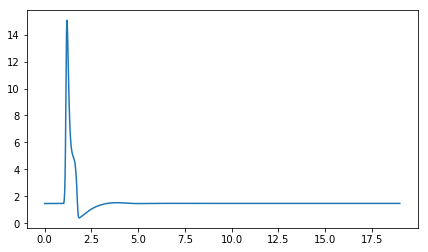

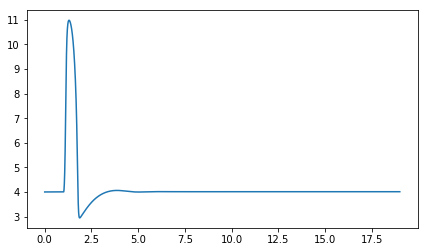

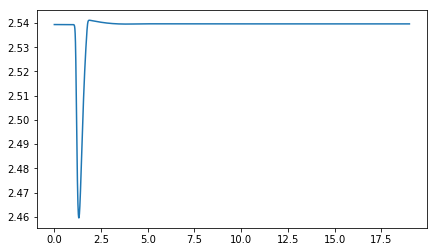

In [18]:
aa.plot(aa.i_ip3r(c, c_t, hh, ip))
aa.plot(aa.i_serca(c))
aa.plot(aa.i_leak(c, c_t))

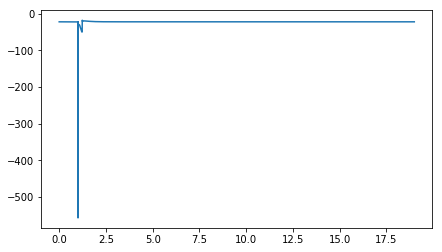

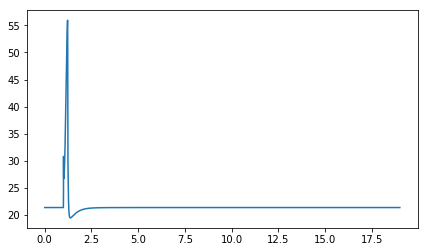

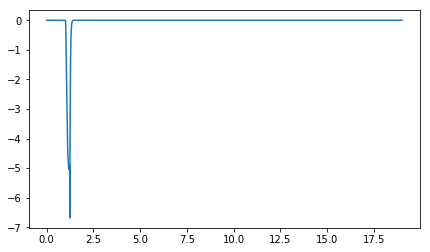

In [19]:
aa.plot(aa.i_na(v,m,h))
aa.plot(aa.i_k(v,n))
aa.plot(aa.i_cal(v, m_cal, h_cal))

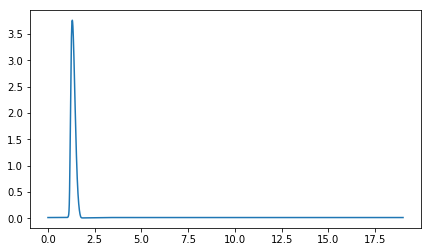

In [20]:
aa.plot(aa.i_pmca(c))

In [21]:
f_encoder = KatoForceEncoder(c/1e6)
force = f_encoder.step()[:,1]/f_encoder.m2max

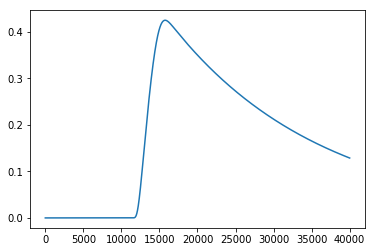

In [22]:
plt.plot(force[0:40000])

In [38]:
np.savetxt("f.csv", np.array([aa.time, force]).T[0:150000], delimiter=",")

In [29]:
np.array([aa.time, force])[0:150000].shape

(2, 200000)

In [37]:
np.array([aa.time, force]).T[0:150000].shape

(150000, 2)